In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
np.set_printoptions(precision=2, linewidth=120)
from copy import copy
from tqdm import *
from drift_qec.Q import *

/Users/yan/.miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


- Original basis `Q0`
- Recovered basis `Qc` (Controlled-bsais)
- Effected basis `Qeff = Qt.T * Q0`
- Use effected basis for error sampling
- Learn `Qt` progressively better
- When data comes in from the `Qeff` alignment, you must transform it back to the standard basis before average with the existing channel estimate

Error x Time x Cycle_ratio

In [ ]:
D = 0.01
N_ERRORS = 1e6
N_TRIALS = 100
N_CYCLES = np.logspace(1, 3, 10).astype(np.int)
RECORDS = []
for trial in tqdm(range(N_TRIALS)):
    for n_cycles in N_CYCLES:
        n = int(N_ERRORS / n_cycles)
        channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                          Q=np.linalg.qr(np.random.randn(3,3))[0],
                          n=n, d=D)

        RECORDS.append({
                "trial": trial,
                "cycle_length": n,
                "n_cycles": n_cycles,
                "time": 0,
                "Mdist": np.linalg.norm(channel.Mhat-channel.C),
                "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3))
            })
        for cycle in range(n_cycles):
            channel.update()
            RECORDS.append({
                    "trial": trial,
                    "cycle_length": n,
                    "n_cycles": n_cycles,
                    "time": (cycle+1)*n,
                    "Mdist": np.linalg.norm(channel.Mhat-channel.C),
                    "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3))
                })

df = pd.DataFrame(RECORDS)
df.to_csv("{}errorsd{}.csv".format(N_ERRORS,D))

In [ ]:
df["cycle_length"] = (N_ERRORS / df["n_cycles"]).astype(np.int)

In [ ]:
df.tail(10)

In [ ]:
PAL = sns.color_palette("hls", len(N_CYCLES))
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for idx, n_cycles in enumerate(N_CYCLES):
    sel = (df["n_cycles"] == n_cycles)
    subdf = df.loc[sel, :]
    v = subdf.groupby("time").mean()
    s = subdf.groupby("time").std()
    t = v.index.values
    y = v["Mdist"].values
    e = s["Mdist"].values
    ax.loglog(t, y, label=str(subdf.iloc[0, 2]), c=PAL[idx])
    ax.fill_between(t, y-e, y+e, alpha=0.1, color=PAL[idx])
plt.title("Recover error over time for varied ratios of cycles to realignments")
plt.xlabel("Time [cycles]")
plt.ylabel("Basis recovery error")
plt.legend()

## Regime 1 basis alignment

In [73]:
D = 0.01
N_TRIALS = 100
MAX_N = int(1e6)
N_STEP = int(1e3)
RECORDS = []
for trial in tqdm(range(N_TRIALS)):
    channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                      Q=np.linalg.qr(np.random.randn(3,3))[0],
                      n=N_STEP, d=D)
    pxhat, pyhat, pzhat = list(np.linalg.svd(channel.Mhat)[1])
    RECORDS.append({
            "trial": trial,
            "time": 0,
            "Mdist": np.linalg.norm(channel.Mhat-channel.C),
            "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
            "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
            "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
        })
    for time in range(0, MAX_N, N_STEP):
        channel.update()
        pxhat, pyhat, pzhat = list(np.linalg.svd(channel.Mhat)[1])
        RECORDS.append({
                "trial": trial,
                "time": time,
                "Mdist": np.linalg.norm(channel.Mhat-channel.C),
                "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
                "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
                "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
            })

df = pd.DataFrame(RECORDS)
df.to_csv("regime1.csv")

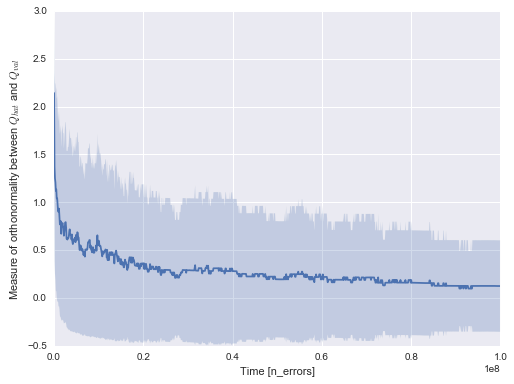

In [24]:
df = pd.read_csv("regime1.csv")
v = df.groupby("time").mean()["Qdist"]
s = df.groupby("time").std()["Qdist"]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
t = v.index.values
y = v.values
e = s.values
ax.plot(t, y,)
ax.fill_between(t, y-e, y+e, alpha=0.25)
plt.ylabel("Measure of orthonormality between $Q_{hat}$ and $Q_{val}$")
plt.xlabel("Time [n_errors]")

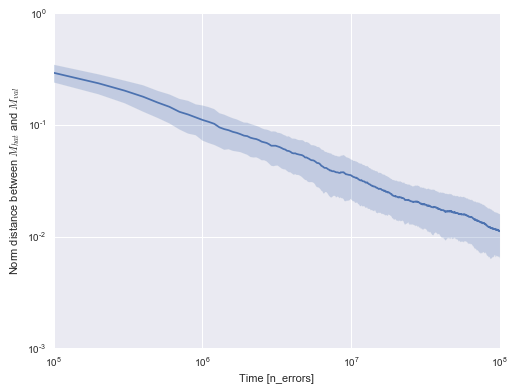

In [44]:
df = pd.read_csv("regime1.csv")
v = df.groupby("time").mean()["Mdist"]
s = df.groupby("time").std()["Mdist"]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
t = v.index.values
y = v.values
e = s.values
ax.loglog(t, y,)
ax.fill_between(t, y-e, y+e, alpha=0.25)
plt.ylabel("Norm distance between $M_{hat}$ and $M_{val}$")
plt.xlabel("Time [n_errors]")

## Regime 2 basis alignment

In [72]:
D = 0.01
N_TRIALS = 100
MAX_N = int(1e6)
N_STEP = int(1e3)
RECORDS = []
for trial in tqdm(range(N_TRIALS)):
    channel = Channel(kx=0.985, ky=0.01, kz=0.005,
                      Q=np.linalg.qr(np.random.randn(3,3))[0],
                      n=N_STEP, d=D)
    pxhat, pyhat, pzhat = list(np.linalg.svd(channel.Mhat)[1])
    RECORDS.append({
            "trial": trial,
            "time": 0,
            "Mdist": np.linalg.norm(channel.Mhat-channel.C),
            "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
            "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
            "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
        })
    for time in range(0, MAX_N, N_STEP):
        channel.update()
        pxhat, pyhat, pzhat = list(np.linalg.svd(channel.Mhat)[1])
        RECORDS.append({
                "trial": trial,
                "time": time,
                "Mdist": np.linalg.norm(channel.Mhat-channel.C),
                "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
                "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
                "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
            })

df = pd.DataFrame(RECORDS)
df.to_csv("regime2.csv")

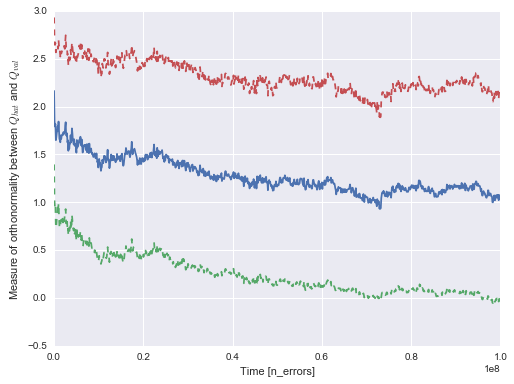

In [41]:
df = pd.read_csv("regime2.csv")
v = df.groupby("time").mean()["Qdist"]
s = df.groupby("time").std()["Qdist"]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
t = v.index.values
y = v.values
e = s.values
ax.plot(t, y)
ax.plot(t, y-e, ls="--")
ax.plot(t, y+e, ls="--")
plt.ylabel("Measure of orthonormality between $Q_{hat}$ and $Q_{val}$")
plt.xlabel("Time [n_errors]")

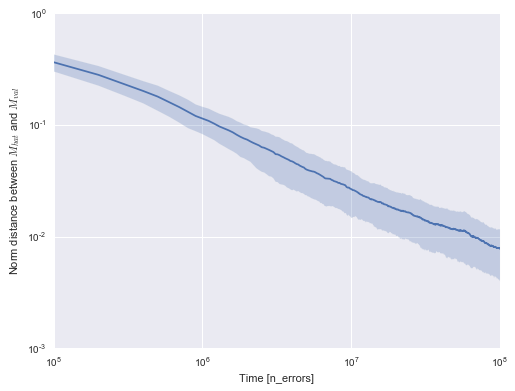

In [39]:
df = pd.read_csv("regime2.csv")
v = df.groupby("time").mean()["Mdist"]
s = df.groupby("time").std()["Mdist"]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
t = v.index.values
y = v.values
e = s.values
ax.loglog(t, y)
ax.fill_between(t, y-e, y+e, alpha=0.25)
plt.ylabel("Norm distance between $M_{hat}$ and $M_{val}$")
plt.xlabel("Time [n_errors]")

# The only thing that matters: effective error probabilities

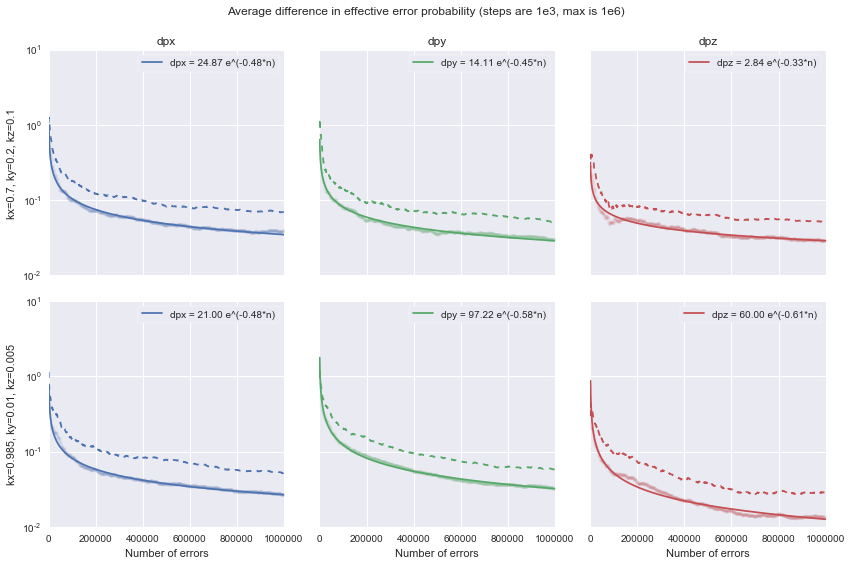

In [128]:
df1 = pd.read_csv("regime1_1e3_1e6.csv")
df1["dpx"] = np.abs(df1["pxval"] - df1["pxhat"])
df1["dpy"] = np.abs(df1["pyval"] - df1["pyhat"])
df1["dpz"] = np.abs(df1["pzval"] - df1["pzhat"])

v1 = df1.groupby("time").mean()
s1 = df1.groupby("time").std()

df2 = pd.read_csv("regime2_1e3_1e6.csv")
df2["dpx"] = np.abs(df2["pxval"] - df2["pxhat"])
df2["dpy"] = np.abs(df2["pyval"] - df2["pyhat"])
df2["dpz"] = np.abs(df2["pzval"] - df2["pzhat"])

v2 = df2.groupby("time").mean()
s2 = df2.groupby("time").std()


fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey=True, sharex=True,
                        tight_layout={"h_pad": 1.0, "rect": [0.0, 0.0, 1.0, 0.95]})
for idx, stat in enumerate(["dpx", "dpy", "dpz"]):
    t1 = v1[stat].index.values
    y1 = v1[stat].values
    e1 = s1[stat].values
    x = np.log(v1.loc[1:, stat].index.values)
    y = np.log(v1.loc[1:, stat].values)
    reg = sp.stats.linregress(x, y)
    fitted = np.exp(reg.intercept + reg.slope * x)
    axs[0, idx].semilogy(t1, y1, ls="", marker=".", color=sns.color_palette()[idx], alpha=0.05)
    axs[0, idx].semilogy(t1, y1+e1, ls="--", color=sns.color_palette()[idx])
    axs[0, idx].semilogy(t1[1:], fitted, ls="-", color=sns.color_palette()[idx],
                         label="{} = {:0.2f} e^({:0.2f}*n)".format(stat, np.exp(reg.intercept), reg.slope))
    axs[0, idx].set_title(stat)
    axs[0, idx].legend(frameon=True)
    
    t2 = v2[stat].index.values
    y2 = v2[stat].values
    e2 = s2[stat].values
    x = np.log(v2.loc[1:, stat].index.values)
    y = np.log(v2.loc[1:, stat].values)
    reg = sp.stats.linregress(x, y)
    fitted = np.exp(reg.intercept + reg.slope * x)
    axs[1, idx].semilogy(t2, y2, ls="", marker=".", color=sns.color_palette()[idx], alpha=0.05)
    axs[1, idx].semilogy(t2, y2+e2, ls="--", color=sns.color_palette()[idx])
    axs[1, idx].semilogy(t2[1:], fitted, ls="-", color=sns.color_palette()[idx],
                         label="{} = {:0.2f} e^({:0.2f}*n)".format(stat, np.exp(reg.intercept), reg.slope))
    axs[1, idx].set_xlabel("Number of errors")
    axs[1, idx].legend(frameon=True)

fig.suptitle("Average difference in effective error probability (steps are 1e3, max is 1e6)")
axs[0, 0].set_ylabel("kx=0.7, ky=0.2, kz=0.1")
axs[1, 0].set_ylabel("kx=0.985, ky=0.01, kz=0.005")
fig.savefig("dp_1e3_1e6.pdf")

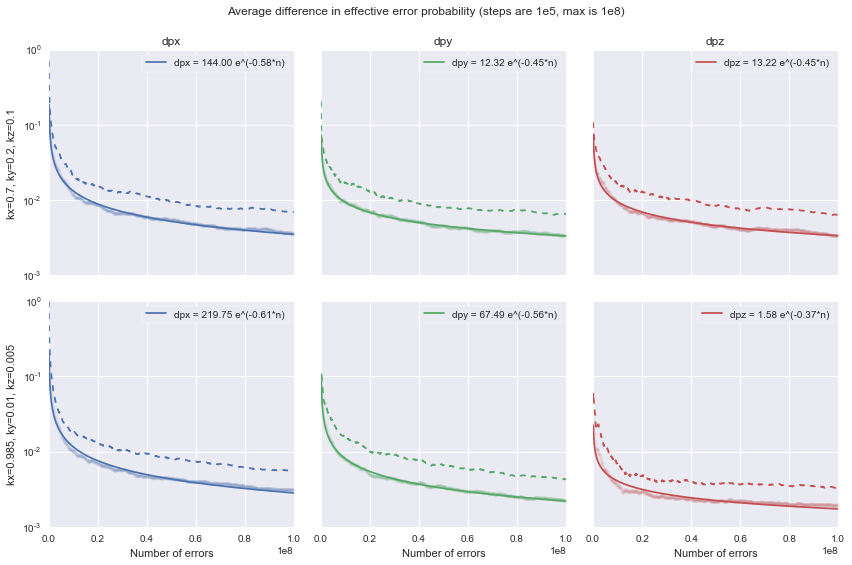

In [130]:
df1 = pd.read_csv("regime1_1e5_1e8.csv")
df1["dpx"] = np.abs(df1["pxval"] - df1["pxhat"])
df1["dpy"] = np.abs(df1["pyval"] - df1["pyhat"])
df1["dpz"] = np.abs(df1["pzval"] - df1["pzhat"])

v1 = df1.groupby("time").mean()
s1 = df1.groupby("time").std()

df2 = pd.read_csv("regime2_1e5_1e8.csv")
df2["dpx"] = np.abs(df2["pxval"] - df2["pxhat"])
df2["dpy"] = np.abs(df2["pyval"] - df2["pyhat"])
df2["dpz"] = np.abs(df2["pzval"] - df2["pzhat"])

v2 = df2.groupby("time").mean()
s2 = df2.groupby("time").std()


fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey=True, sharex=True,
                        tight_layout={"h_pad": 1.0, "rect": [0.0, 0.0, 1.0, 0.95]})
for idx, stat in enumerate(["dpx", "dpy", "dpz"]):
    t1 = v1[stat].index.values
    y1 = v1[stat].values
    e1 = s1[stat].values
    x = np.log(v1.loc[1:, stat].index.values)
    y = np.log(v1.loc[1:, stat].values)
    reg = sp.stats.linregress(x, y)
    fitted = np.exp(reg.intercept + reg.slope * x)
    axs[0, idx].semilogy(t1, y1, ls="", marker=".", color=sns.color_palette()[idx], alpha=0.05)
    axs[0, idx].semilogy(t1, y1+e1, ls="--", color=sns.color_palette()[idx])
    axs[0, idx].semilogy(t1[1:], fitted, ls="-", color=sns.color_palette()[idx],
                         label="{} = {:0.2f} e^({:0.2f}*n)".format(stat, np.exp(reg.intercept), reg.slope))
    axs[0, idx].set_title(stat)
    axs[0, idx].legend(frameon=True)
    
    t2 = v2[stat].index.values
    y2 = v2[stat].values
    e2 = s2[stat].values
    x = np.log(v2.loc[1:, stat].index.values)
    y = np.log(v2.loc[1:, stat].values)
    reg = sp.stats.linregress(x, y)
    fitted = np.exp(reg.intercept + reg.slope * x)
    axs[1, idx].semilogy(t2, y2, ls="", marker=".", color=sns.color_palette()[idx], alpha=0.05)
    axs[1, idx].semilogy(t2, y2+e2, ls="--", color=sns.color_palette()[idx])
    axs[1, idx].semilogy(t2[1:], fitted, ls="-", color=sns.color_palette()[idx],
                         label="{} = {:0.2f} e^({:0.2f}*n)".format(stat, np.exp(reg.intercept), reg.slope))
    axs[1, idx].set_xlabel("Number of errors")
    axs[1, idx].legend(frameon=True)

fig.suptitle("Average difference in effective error probability (steps are 1e5, max is 1e8)")
axs[0, 0].set_ylabel("kx=0.7, ky=0.2, kz=0.1")
axs[1, 0].set_ylabel("kx=0.985, ky=0.01, kz=0.005")
fig.savefig("dp_1e5_1e8.pdf")

In [139]:
sel = (df1["pxhat"] + df1["pyhat"] + df1["pzhat"]) != 1.0
df1.loc[sel, :]

,Unnamed: 0,Mdist,Qdist,pxhat,pxval,pyhat,pyval,pzhat,pzval,time,trial,dpx,dpy,dpz
0,0,0.734847,2.803587,0.000000,0.7,0.000000,0.2,0.000000,0.1,0,0,0.700000,0.200000,0.100000
1,1,0.405185,2.370878,0.470949,0.7,0.118071,0.2,0.089020,0.1,0,0,0.229051,0.081929,0.010980
2,2,0.242568,1.763047,0.571959,0.7,0.076309,0.2,0.018399,0.1,100000,0,0.128041,0.123691,0.081601
3,3,0.201645,1.169681,0.575882,0.7,0.119263,0.2,0.054855,0.1,200000,0,0.124118,0.080737,0.045145
4,4,0.136823,0.133849,0.608238,0.7,0.175259,0.2,0.016503,0.1,300000,0,0.091762,0.024741,0.083497
5,5,0.117847,0.280169,0.641452,0.7,0.158583,0.2,0.033298,0.1,400000,0,0.058548,0.041417,0.066702
6,6,0.142610,0.597606,0.650735,0.7,0.190954,0.2,0.015455,0.1,500000,0,0.049265,0.009046,0.084545
7,7,0.142894,0.715272,0.656896,0.7,0.194477,0.2,0.023627,0.1,600000,0,0.043104,0.005523,0.076373
8,8,0.122484,0.597707,0.664567,0.7,0.193098,0.2,0.031224,0.1,700000,0,0.035433,0.006902,0.068776
9,9,0.157521,0.854233,0.689928,0.7,0.192033,0.2,0.018039,0.1,800000,0,0.010072,0.007967,0.081961


## Constant p_uncorr advantages in regimes 1 and 2

In [132]:
print "Regime 1 advantage: {}".format((1.5 / (1.0-0.7))**2)
print "Regime 2 advantage: {}".format((1.5 / (1.0-0.985))**2)

Regime 1 advantage: 25.0
Regime 2 advantage: 10000.0


Regime 2 lands kz within 0.002 of it's value of 0.005. That's good!

## TRY UPDATING every 10 steps
This will be indicative of whether drifting case is worth it.